In [1]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np 

In [2]:
%matplotlib inline
import matplotlib 
from matplotlib import pyplot as plt
from skimage.transform import resize

In [3]:
def prepare_datasets(string):
    input_data = []
    target_data = []
    img_paths = open(string+'image_list.txt','r')
    n = 0
    p = 0
    for i in img_paths.readlines():
        a = i.split()
        if a[1] == str(p):
            if n<200:
                b = matplotlib.image.imread(string+a[0])
                b_r = resize(b, (224,224,3))
                input_data.append(b_r)
                target = np.array(p).reshape(-1)
                onehot = np.eye(12)[target]
                target_data.append(onehot)
                n = n+1
            else:
                p = p+1
                n = 0 
    np_input_data = np.array(input_data)
    np_target_data = np.array(target_data)
    np_target_data = np.reshape(np_target_data, (2400,12))
    #np_input_data, np_target_data = np_input_data/255.0, np_target_data/255.0
    np_input_data, np_target_data = np_input_data.astype('float32'), np_target_data.astype('float32')
    return np_input_data, np_target_data

In [4]:
np_input_source_data, np_target_source_data = prepare_datasets('train/')

In [5]:
np_input_target_data, np_target_target_data = prepare_datasets('validation/')

In [6]:
np_input_source_data.shape

(2400, 224, 224, 3)

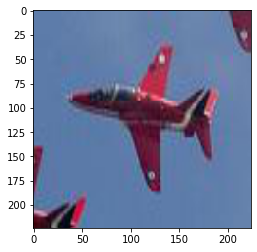

In [7]:
plt.imshow(np_input_target_data[34])

In [10]:
source_dataset = tf.data.Dataset.from_tensor_slices((np_input_source_data, np_target_source_data)).shuffle(1000).batch(64)

In [12]:
da_dataset = da_dataset = tf.data.Dataset.from_tensor_slices((np_input_source_data, np_target_source_data, np_input_target_data, np_target_target_data)).shuffle(1000).batch(32)

In [14]:
@tf.custom_gradient
def gradient_layer(x, lamda=1.0):
    y = tf.identity(x)
    def grad(dy):
        return lamda*-dy, None
    return y, grad

In [15]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=1.0):
        return gradient_layer(x, lamda)

In [19]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, MaxPool2D, Dense, Flatten

In [52]:
class DANN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.feature_extractor_layer0 = Conv2D(32, kernel_size=(3,3), activation='relu')
        self.feature_extractor_layer1 = BatchNormalization()
        self.feature_extractor_layer2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        self.feature_extractor_layer3 = Conv2D(64, kernel_size=(5, 5), activation='relu')
        self.feature_extractor_layer4 = Dropout(0.5)
        self.feature_extractor_layer5 = BatchNormalization()
        self.feature_extractor_layer6 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        
        self.label_predictor_layer0 = Dense(100, activation='relu')
        self.label_predictor_layer1 = Dense(100, activation='relu')
        self.label_predictor_layer2 = Dense(12, activation=None)
        
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = Dense(100, activation='relu')
        self.domain_predictor_layer2 = Dense(2, activation=None)
        
    def call(self, x, train=False, source_train=True, lamda=1.0):
        #Feature Extractor
        x = self.feature_extractor_layer0(x)
        x = self.feature_extractor_layer1(x, training=train)
        x = self.feature_extractor_layer2(x)
        
        x = self.feature_extractor_layer3(x)
        x = self.feature_extractor_layer4(x, training=train)
        x = self.feature_extractor_layer5(x, training=train)
        x = self.feature_extractor_layer6(x)
        
        feature = tf.reshape(x, [-1, 53 * 53 * 64])
        
        #Label Predictor
        if source_train is True:
            feature_slice = feature
        else:
            feature_slice = tf.slice(feature, [0, 0], [feature.shape[0] // 2, -1])
        
        lp_x = self.label_predictor_layer0(feature_slice)
        lp_x = self.label_predictor_layer1(lp_x)
        l_logits = self.label_predictor_layer2(lp_x)
        
        #Domain Predictor
        if source_train is True:
            return l_logits
        else:
            dp_x = self.domain_predictor_layer0(feature, lamda)    #GradientReversalLayer
            dp_x = self.domain_predictor_layer1(dp_x)
            d_logits = self.domain_predictor_layer2(dp_x)
            
            return l_logits, d_logits

In [53]:
model = DANN()

In [54]:
#def loss_func(input_logits, target_labels):
#    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#    return tf.reduce_mean(loss_function(target_labels, input_logits))
def loss_func(input_logits, target_labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=input_logits, labels=target_labels))

def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
        return loss_func(l_logits, labels)
    else:
        return loss_func(l_logits, labels) + loss_func(d_logits, domain)


model_optimizer = tf.optimizers.SGD()

In [55]:
domain_labels = np.vstack([np.tile([1., 0.], [32, 1]),
                           np.tile([0., 1.], [32, 1])])
domain_labels = domain_labels.astype('float32')


In [56]:
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
source_acc = []  # Source Domain Accuracy while Source-only Training
da_acc = []      # Source Domain Accuracy while DA-training

In [57]:
@tf.function
def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda)
        
        model_loss = get_loss(output, labels)
        epoch_accuracy(output, labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))

In [58]:
@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], 0)
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)
        
        model_loss = get_loss(output[0], labels, output[1], domain_labels)
        epoch_accuracy(output[0], labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))

In [59]:
def train(train_mode, epochs):
    
    if train_mode == 'source':
        dataset = source_dataset
        train_func = train_step_source
        acc_list = source_acc
    elif train_mode == 'domain-adaptation':
        dataset = da_dataset
        train_func = train_step_da
        acc_list = da_acc
    else:
        raise ValueError("Unknown training Mode")
    
    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = 2 / (1 + np.exp(-100 * p, dtype=np.float32)) - 1
        lamda = lamda.astype('float32')

        for batch in dataset:
            train_func(*batch, lamda=lamda)
        
        print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()), end='  |  ')
        acc_list.append(epoch_accuracy.result())
        #test()
        epoch_accuracy.reset_states()

In [60]:
train('source', 5)

Training: Epoch 0 :	 Source Accuracy : 22.417%  |  Training: Epoch 1 :	 Source Accuracy : 43.000%  |  Training: Epoch 2 :	 Source Accuracy : 51.958%  |  Training: Epoch 3 :	 Source Accuracy : 62.292%  |  Training: Epoch 4 :	 Source Accuracy : 69.458%  |  

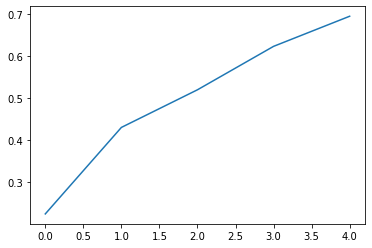

In [61]:
x_axis = [i for i in range(0, 5)]
plt.plot(x_axis, source_acc, label="source accuracy")

In [68]:
test_img = np_input_source_data[200]
test_img.shape

(224, 224, 3)

In [69]:
test_img = np.reshape(test_img, (-1,224,224,3))
test_img.shape

(1, 224, 224, 3)

In [70]:
d = model(test_img, train=True, source_train=True, lamda=1.0)

In [71]:
tf.nn.softmax(d)

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[0.34946758, 0.0132971 , 0.01189534, 0.05284447, 0.10704631,
        0.0014446 , 0.01950392, 0.01026255, 0.00902222, 0.3698215 ,
        0.04266312, 0.01273138]], dtype=float32)>

In [72]:
train('domain-adaptation', 10)

Training: Epoch 0 :	 Source Accuracy : 12.208%  |  Training: Epoch 1 :	 Source Accuracy : 17.167%  |  Training: Epoch 2 :	 Source Accuracy : 18.750%  |  Training: Epoch 3 :	 Source Accuracy : 21.083%  |  Training: Epoch 4 :	 Source Accuracy : 23.208%  |  Training: Epoch 5 :	 Source Accuracy : 24.167%  |  Training: Epoch 6 :	 Source Accuracy : 28.083%  |  Training: Epoch 7 :	 Source Accuracy : 29.917%  |  Training: Epoch 8 :	 Source Accuracy : 30.833%  |  Training: Epoch 9 :	 Source Accuracy : 33.375%  |  

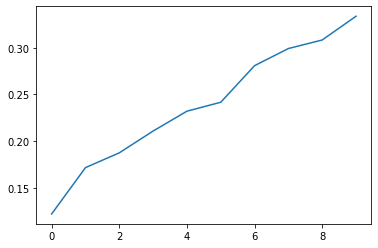

In [76]:
x_axis = [i for i in range(0, 10)]
plt.plot(x_axis, da_acc, label="domain adaptation accuracy")

In [75]:
model.save('.', save_format='tf')

INFO:tensorflow:Assets written to: ./assets
